In this project, I plan to build an ML based recommender which gives a housing price recommendation based on some input variables related to the house (e.g location, #bedrooms, etc). I will be using a regression model, and using a (raw, uncleaned) dataset that has been scraped from an online web-based housing marketplace, "Rumah.com". This narrows the project's scope to data on houses in my hometown, South Tangerang, in Indonesia. 
\
\
Link to dataset, scraped by Gerry Zani - https://www.kaggle.com/datasets/gerryzani/housing-price-in-south-tangerang-city-indonesia/data 

Project Outline
1) Setup & Preprocessing
2) Data Cleaning
3) Feature Engineering & Feature Selection
4) Regression Model & Evaluation

First, setting up. Here, I'm just going to load the main python packages that I'll be using, and get a brief glance into the dataset.

In [4]:
#Loading Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading dataset
housing_data = pd.read_csv('HousingData.csv', encoding = 'unicode_escape')
housing_data.head()

,nav-link href,listing-location,price,bed,bath,listing-floorarea,listing-floorarea 2
0,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","6,9 M",5.0,5.0,420 m²,Rp 20.720.721 per m²
1,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","4,5 M",3.0,3.0,190 m²,Rp 12.747.875 per m²
2,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,95 M",3.0,3.0,132 m²,Rp 30.859.375 per m²
3,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,3 M",4.0,3.0,220 m²,Rp 18.333.333 per m²
4,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,5 M",3.0,2.0,180 m²,Rp 27.777.778 per m²


Now I'd like to do some simple pre-processing before moving on. First, I'd like to rename some columns for ease and clarity. Second, price per area (listing-floorarea 2) is just price divided by area (obviously), and both of these are already variables in this dataset. I will be discarding that column. This is a column I'll be dropping. Lastly, this dataset does contain duplicates, as stated by the owner, so I'll be dropping duplicates now to avoid errors.

In [6]:
housing_data = housing_data.rename(columns = {'nav-link href':'url', 'listing-location': 'location',
                               'listing-floorarea':'area'})

housing_data = housing_data.drop(columns = 'listing-floorarea 2')
housing_data.drop_duplicates()

housing_data.head()

,url,location,price,bed,bath,area
0,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","6,9 M",5.0,5.0,420 m²
1,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","4,5 M",3.0,3.0,190 m²
2,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,95 M",3.0,3.0,132 m²
3,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,3 M",4.0,3.0,220 m²
4,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten","3,5 M",3.0,2.0,180 m²


Now onto data cleaning. Here I'll be dealing with the variables 'bed', 'bath', 'area', and the target variable 'price'. These have missing values, and non-numerical datatypes, as seen above.

In [8]:
housing_data.isnull().sum()[0:6]

url           0
location      0
price         0
bed         138
bath        205
area          0
dtype: int64

In [9]:
housing_data['area'].str[-3:].value_counts()

area
m²    29420
Name: count, dtype: int64

In [10]:
housing_data['price'].str[-2:].value_counts()

price
 M    24584
jt     4725
00       41
rb       14
89        8
50        8
99        6
71        4
75        3
95        3
78        3
25        2
48        2
80        2
30        2
1         2
4         2
59        1
72        1
62        1
70        1
93        1
85        1
54        1
29        1
10        1
Name: count, dtype: int64

1) the columns bed and bath have missing values. I'll be filling them with the median value.
2) all area values end in meters squared, which is the unit of measurement for this variable. Hence I'll remove this and convert the column into int, so that we can work with numerical values.
3) location - Seeing the most common suffixes, I see that they are also orders of magnitude, but written in the Indonesian language. More specificallty, "jt" means million, "M" means billion, "rb" means thousand, and commas are decimal points in Indonesian standards. With this in mind, we can map these strings into numerical values.

In [12]:
def clean(data):
    data['bed'] = data['bed'].fillna(data['bed'].median())
    data['bath'] = data['bath'].fillna(data['bath'].median())
    data.area = data.area.astype(str)
    data['area'] = data['area'].str[:-3].astype(int)

def transform_price(price):
    try:
        price = price.replace(',', '.')
        
        # Step 2: Extract the numeric value and suffix
        suffix = price[-2:]  # Last two characters (e.g., "rb", "jt", "M")
        
        # Step 3: Handle suffix cases and multiply accordingly
        if suffix == 'jt':
            price_value = float(price[:-2]) * 1_000_000
        elif suffix == ' M':
            price_value = float(price[:-2]) * 1_000_000_000
        elif suffix == 'rb':
            price_value = float(price[:-2]) * 1_000
        else:
            price_value = float(price)
        return price_value
    
    except (ValueError, TypeError) as e:
        return None
    
clean(housing_data)
housing_data['price'] = housing_data['price'].apply(transform_price)
housing_data = housing_data.dropna()
housing_data.head()

,url,location,price,bed,bath,area
0,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten",6.900000e+09,5.0,5.0,420
1,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten",4.500000e+09,3.0,3.0,190
2,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten",3.950000e+09,3.0,3.0,132
3,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten",3.300000e+09,4.0,3.0,220
4,https://www.rumah.com/listing-properti/dijual-...,"Gading Serpong, Tangerang Selatan, Banten",3.500000e+09,3.0,2.0,180


Now let's look into descriptive statistics of our semi-cleaned dataset, and deal with outliers.

In [14]:
housing_data.describe()

,price,bed,bath,area
count,2.941600e+04,29416.000000,29416.000000,29416.000000
mean,3.565221e+09,3.755745,2.986334,220.585872
std,6.810679e+09,1.353687,1.355098,3395.996260
min,1.000000e+00,1.000000,1.000000,1.000000
25%,1.350000e+09,3.000000,2.000000,80.000000
50%,2.450000e+09,4.000000,3.000000,140.000000
75%,4.300000e+09,4.000000,4.000000,236.000000
max,8.500000e+11,10.000000,10.000000,400000.000000


bed and bath, which represent the number of bedrooms and bathrooms, have reasonably realistic values, so we don't have to deal with this column.
\
\
On the other hand, the max and standard deviation for the values of area is ridiculous. Furthermore, the minimum value for the price is 1 Indonesian Rupiah (imagine one house costing less than $0.01 USD). I think it's best we exclude outliers from both 'price' and 'area', and let the model extrapolate for unrealistic/ridiculous inputs of area. 

In [16]:
for col in ['area','price']:
    Q1 = housing_data[col].quantile(0.25)
    Q3 = housing_data[col].quantile(0.75)
    IQR = Q3 - Q1

    #being a bit generous with 4xIQR, with the standard being 1.5 from what I know, but I'm being generous just to filter out troll/scam postings
    lower_bound = Q1 - 4 * IQR
    upper_bound = Q3 + 4 * IQR


    housing_data = housing_data[(housing_data[col] >= lower_bound) & (housing_data[col] <= upper_bound)]
housing_data.describe()

,price,bed,bath,area
count,2.882900e+04,28829.000000,28829.000000,28829.000000
mean,3.125182e+09,3.712130,2.934268,172.541469
std,2.567361e+09,1.305999,1.289271,125.354774
min,1.000000e+00,1.000000,1.000000,1.000000
25%,1.350000e+09,3.000000,2.000000,80.000000
50%,2.400000e+09,4.000000,3.000000,137.000000
75%,4.100000e+09,4.000000,4.000000,225.000000
max,1.565913e+10,10.000000,10.000000,825.000000


The IQR method of removing outliers didn't exclude unrealistically low prices (think 1 cent for a house), and low areas (think a house the size of a desk). I'll use my judgment here based on what I have seen and what I know about Indonesian property, to exclude such values.

In [18]:
area_lower_bound = 15
price_lower_bound = 10**7
housing_data = housing_data[(housing_data['area'] >= area_lower_bound)]
housing_data = housing_data[(housing_data['price'] >= price_lower_bound)]

housing_data.describe()

,price,bed,bath,area
count,2.859100e+04,28591.000000,28591.00000,28591.000000
mean,3.149883e+09,3.718968,2.94215,173.364940
std,2.562888e+09,1.305394,1.28739,125.378545
min,1.200000e+07,1.000000,1.00000,21.000000
25%,1.350000e+09,3.000000,2.00000,80.000000
50%,2.400000e+09,4.000000,3.00000,139.000000
75%,4.100456e+09,4.000000,4.00000,225.000000
max,1.565913e+10,10.000000,10.00000,825.000000


Seems reasonable now. Let's move on to the last feature, location. Since it is in text, I'd like to put it all in lower case, to make data entries more consistent with each other.

In [20]:
housing_data.location = housing_data.location.str.lower()
housing_data.location.str.lower().value_counts()

location
bintaro, tangerang selatan, banten                                                    4387
bsd, tangerang selatan, banten                                                        2356
gading serpong, tangerang selatan, banten                                              731
ciputat, tangerang selatan, banten                                                     654
bintaro sektor 9, bintaro, tangerang selatan, banten                                   617
                                                                                      ... 
. jalan otista raya no.23, ciputat, tangerang selatan, banten                            1
latigo, gading serpong, tangerang selatan, banten                                        1
komplek grand bintaro asri, ciputat timur, tangerang selatan, banten                     1
fortune district graha raya bintaro jaya, serpong utara, tangerang selatan, banten       1
jombang pondok aren, pondok aren, tangerang selatan, banten                      

Format still isn't consistent. There are different levels of specificity accepted, with some only having the district specified, others having it down to the street and even house number. Instead, I'd like to look into the most common words that appear here, and make numerical variables out of that, with OneHotEncoder. I'll visualize this with a wordcloud too.

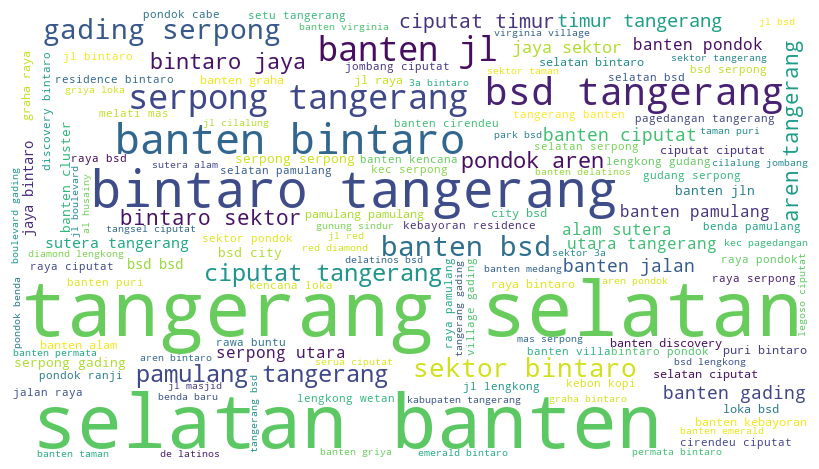

Top 25 words:
[('tangerang', 30283), ('selatan', 29856), ('banten', 28883), ('bintaro', 15690), ('serpong', 7222), ('bsd', 7202), ('ciputat', 4128), ('sektor', 3154), ('gading', 2873), ('pamulang', 2818), ('pondok', 2363), ('jl.', 2137), ('raya', 1881), ('jaya', 1876), ('aren', 1779), ('9', 1753), ('jl', 1659), ('timur', 1514), ('jalan', 1264), ('sutera', 1080), ('utara', 972), ('alam', 930), ('cluster', 722), ('city', 580), ('lengkong', 567)]


In [22]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

all_locations = " ".join(housing_data['location'])
words = all_locations.replace(",", "").split()

wordcloud = WordCloud(width=800, height=450,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(" ".join(words))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

word_counts = Counter(words)
print("Top 25 words:")
print(word_counts.most_common(25))

These all have significant enough proportions, when compared to the sample size ( <30000). The first three, which are tangerang, selatan, and banten, are the geographical scope of this dataset anyways, so we can remove them (all houses in this dataset are in Tangerang Selatan, Banten). Hence, we are left with the array below, which I will use for OneHotEncoding. 

In [24]:
RelevantWords = ['bintaro', 'serpong', 'bsd', 'ciputat', 'sektor', 'gading', 'pamulang', 'pondok',
                 'jl.', 'raya','jaya','aren',
                '9','jl','timur','jalan','sutera','utara','alam','cluster','city','lengkong']

for word in RelevantWords:
    # Create a new column for each word, 1 if the word is in the location, else 0
    housing_data[word] = housing_data['location'].str.lower().str.contains(word).astype(int)

#Now we discard the original location column
housing_data = housing_data.drop(columns = 'location')

housing_data.head()

,url,price,bed,bath,area,bintaro,serpong,bsd,ciputat,sektor,...,9,jl,timur,jalan,sutera,utara,alam,cluster,city,lengkong
0,https://www.rumah.com/listing-properti/dijual-...,6.900000e+09,5.0,5.0,420,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.rumah.com/listing-properti/dijual-...,4.500000e+09,3.0,3.0,190,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.rumah.com/listing-properti/dijual-...,3.950000e+09,3.0,3.0,132,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://www.rumah.com/listing-properti/dijual-...,3.300000e+09,4.0,3.0,220,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,https://www.rumah.com/listing-properti/dijual-...,3.500000e+09,3.0,2.0,180,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lastly, the 'url' column. I'd like to take a similar approach, especially seeing that these urls have a consistent format with the dashes, https, etc (knowing that this data is scraped from the same website). In fact, after looking into some of these individual urls, I found that they are just the titles of the house listings, alongside the names of the sellers, etc. We might be able to get some more meaningful features out of this. \
\
Note: each link looks something like https://www.rumah.com/listing-properti/dijual-sagara-residence-at-bsd-city-serpong-tangerang-selatan-cluster-exclusive-oleh-jasmin-k-21825427

In [26]:
housing_data['url'] = housing_data['url'].astype(str)

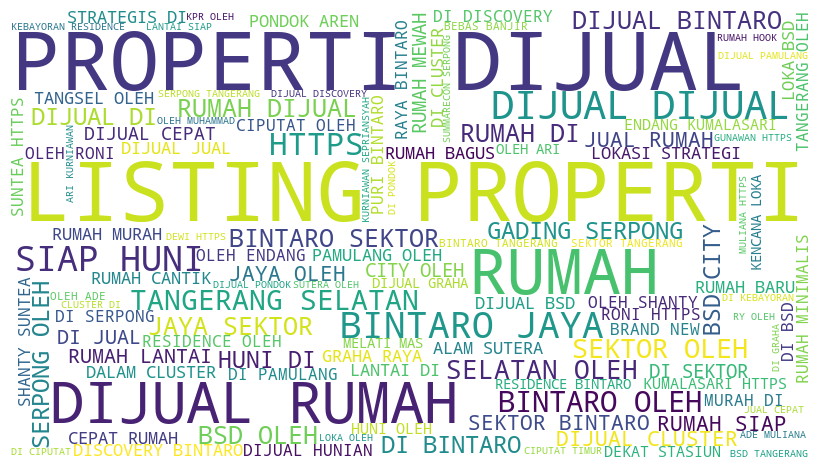

Top 30 words:
[('DIJUAL', 35573), ('PROPERTI', 28600), ('LISTING', 28594), ('HTTPS', 28591), ('WWW.RUMAH.COM', 28591), ('OLEH', 28591), ('RUMAH', 16020), ('DI', 11827), ('BINTARO', 10914), ('SEKTOR', 5358), ('BSD', 5029), ('JAYA', 4138), ('CLUSTER', 3954), ('SERPONG', 3935), ('SIAP', 3796), ('HUNI', 3728), ('TANGERANG', 2969), ('2', 2934), ('9', 2880), ('SELATAN', 2561), ('LANTAI', 2556), ('DEKAT', 2173), ('JUAL', 1756), ('GADING', 1601), ('MURAH', 1585), ('CITY', 1553), ('STRATEGIS', 1527), ('PAMULANG', 1508), ('RESIDENCE', 1487), ('CIPUTAT', 1438)]


In [27]:
all_urls = " ".join(housing_data['url'])

# Replace slashes, colons, and dashes with spaces
all_urls = all_urls.replace(":", " ").replace("/", " ").replace("-", " ")

# Convert to uppercase (so that it won't be confused with our previous features) and split into words
words = all_urls.upper().split()

wordcloud = WordCloud(width=800, height=450,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(" ".join(words))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

word_counts = Counter(words)
print("Top 30 words:")
print(word_counts.most_common(30))

A lot of these words actually represent the location of the house, just like the previous features we created (a lot have the same name anyways). However, I'd like to still observe these since these may or may not be a better predictor than the inputted location. I'd like to exclude words with a higher frequency of appearing than 'DI', since all of these words are generic, and/or are a part of every single url.
\
This leaves us with:

In [29]:
RelevantWords2 = ['SEKTOR', 'BSD', 'JAYA', 'CLUSTER', 'SERPONG', 'SIAP', 'HUNI', 
 '2', '9', 'SELATAN','LANTAI', 'DEKAT',
 'GADING', 'MURAH', 'CITY', 'STRATEGIS','PAMULANG', 'RESIDENCE', 'CIPUTAT']

for word in RelevantWords2:
    # Create a new column for each word, 1 if the word is in the location, else 0
    housing_data[word] = housing_data['url'].str.upper().str.contains(word).astype(int)

#Now we discard the original location column
housing_data = housing_data.drop(columns = 'url')

housing_data.head()

,price,bed,bath,area,bintaro,serpong,bsd,ciputat,sektor,gading,...,SELATAN,LANTAI,DEKAT,GADING,MURAH,CITY,STRATEGIS,PAMULANG,RESIDENCE,CIPUTAT
0,6.900000e+09,5.0,5.0,420,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4.500000e+09,3.0,3.0,190,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3.950000e+09,3.0,3.0,132,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3.300000e+09,4.0,3.0,220,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3.500000e+09,3.0,2.0,180,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Time for Feature Selection.

In [31]:
r2coeffs = {}

y = np.array(housing_data.price)
for col in housing_data.columns:
    x = np.array(housing_data[col])
    r = np.corrcoef(x,y)
    rsquared = r[0][1]**2
    r2coeffs[col] = rsquared

r2coeffs = sorted(r2coeffs.items(), key = lambda x:x[1])
r2coeffs

[('GADING', 1.1251565044819185e-07),
 ('CLUSTER', 3.3801101965318743e-07),
 ('lengkong', 2.2270934974172928e-05),
 ('cluster', 0.00011424631569528067),
 ('gading', 0.00019775430547923893),
 ('RESIDENCE', 0.00047997680966785827),
 ('SIAP', 0.0007310689909830281),
 ('2', 0.0007536273220464989),
 ('city', 0.0008316941112575481),
 ('timur', 0.0008780853474652339),
 ('utara', 0.0010573057020493725),
 ('SELATAN', 0.0013578905840320684),
 ('HUNI', 0.0018869242149949883),
 ('9', 0.0021265460099332426),
 ('STRATEGIS', 0.00274157097328704),
 ('jalan', 0.004411839867774268),
 ('aren', 0.004515653771035746),
 ('CITY', 0.005279925644235323),
 ('bsd', 0.0062149872210804),
 ('BSD', 0.008023559252389281),
 ('pondok', 0.008025359507443146),
 ('CIPUTAT', 0.00806575678099835),
 ('LANTAI', 0.009975489335371564),
 ('serpong', 0.010160084892690983),
 ('jaya', 0.010574660439192791),
 ('SERPONG', 0.011987215177027971),
 ('alam', 0.012141446816719515),
 ('sutera', 0.01278643476303694),
 ('DEKAT', 0.01334520162

To reduce the dimensions in our model, as a way to reduce overfitting, I'll be excluding all variables that have R^2 values of less than 0.01. In the list printed above, this means that every word above 'pondok' will be excluded.

Furthermore, I'll also be dropping columns that represent the same word but appear in both url and location (e.g SERPONG and serpong; in which I'll drop the less correlated one).

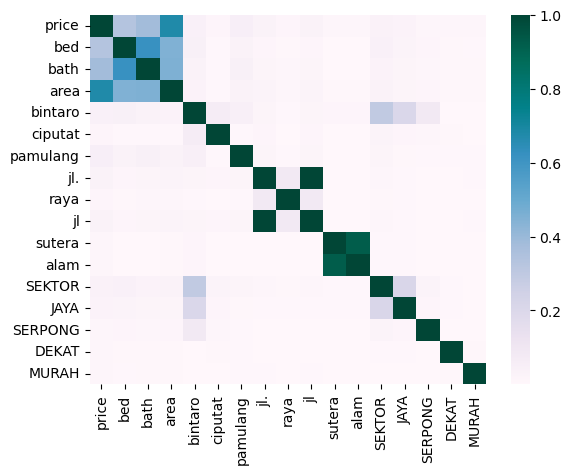

In [33]:
littlecorrelationCols =['GADING','CLUSTER','lengkong','cluster', 'gading', 'RESIDENCE', 'SIAP', '2', 'city', 'timur', 
                        'utara', 'SELATAN','HUNI','9','STRATEGIS','jalan','aren','CITY', 'bsd', 'BSD','pondok','CIPUTAT', 'LANTAI']

redundant = ['serpong', 'jaya','PAMULANG','sektor']

housing_data = housing_data.drop(columns = littlecorrelationCols)
housing_data = housing_data.drop(columns = redundant)

#let's plot the cross correlation values now
sns.heatmap(housing_data.corr(numeric_only = True)**2, cmap = "PuBuGn")
plt.show()

'alam' and 'sutera' are extremely cross correlated, and so is 'jl' and 'jl.'. This is because 'jl' and 'jl.' have the same meaning (shortened word for street), and 'alam sutera' is the name of a neighborhood in the city. Hence, we can drop one of each. We can proceed to the model after this step.

In [35]:
housing_data = housing_data.drop(columns = ['alam', 'jl.'])
housing_data.head()

,price,bed,bath,area,bintaro,ciputat,pamulang,raya,jl,sutera,SEKTOR,JAYA,SERPONG,DEKAT,MURAH
0,6.900000e+09,5.0,5.0,420,0,0,0,0,0,0,0,0,0,0,0
1,4.500000e+09,3.0,3.0,190,0,0,0,0,0,0,0,0,0,0,0
2,3.950000e+09,3.0,3.0,132,0,0,0,0,0,0,0,0,0,0,0
3,3.300000e+09,4.0,3.0,220,0,0,0,0,0,0,0,0,0,0,0
4,3.500000e+09,3.0,2.0,180,0,0,0,0,0,0,0,0,0,0,0


In [36]:
#Splitting the data into training and testing datasets
from sklearn.model_selection import train_test_split
y = housing_data['price'] #I'd like to do a price prediction based on other variables
X = housing_data.drop(columns = 'price')

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 11, test_size = 0.25)

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)
predictions = forest_model.predict(X_val)
print("MAE: ", mean_absolute_error(y_val, predictions))
print("mean of actual values:", y_val.mean())

MAE:  638584550.1660868
mean of actual values: 3164461004.856603


In [38]:
MAPE = round(100*(mean_absolute_error(y_val, predictions)/y_val.mean()))
print("Mean Absolute Prediction Error:", MAPE, "%")

Mean Absolute Prediction Error: 20 %


In [39]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)
predictions = linreg_model.predict(X_val)
print("MAE: ", mean_absolute_error(y_val, predictions))

MAE:  908105050.0202761


In [40]:
from sklearn.svm import SVR 

svr = SVR(kernel='linear') 
svr.fit(X_train, y_train) 
predictions = svr.predict(X_val)
print("MAE: ", mean_absolute_error(y_val, predictions))

MAE:  1671352832.7077227


With just these three models, Random Forest has a lot less error. I believe this may be due to our onehotencoding process, which gives many binary variables, thus making the decision tree/random forest work best with this. Now let's stick to random forest. I'd like to see the impact which the engineered features have on our margin of error. I'm making a new model, but with only the three "main" numerical variables (area, bed, bath).

In [42]:
#Seeing what would the results be without the feature engineering

y = housing_data['price']
X = housing_data[['bed','bath','area']]

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 1, test_size = 0.25)

forest_model2 = RandomForestRegressor(random_state=1)
forest_model2.fit(X_train, y_train)
predictions = forest_model2.predict(X_val)
print("MAE: ", mean_absolute_error(y_val, predictions))
MAPE = round(100*(mean_absolute_error(y_val, predictions)/y_val.mean()))
print("Mean Absolute Prediction Error:", MAPE, "%")

MAE:  721630876.8452765
Mean Absolute Prediction Error: 23 %


From 23% to 20%. 13% decrease (in percentage change).

In [44]:
#What would happen if we didn't discard the likely-fraudulent values AND didn't use the engineered features.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

y = housing_data['price'] 
X = housing_data[['bed','bath','area']]

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 1, test_size = 0.25)

forest_model2 = RandomForestRegressor(random_state=1)
forest_model2.fit(X_train, y_train)
predictions = forest_model2.predict(X_val)
print("MAE: ", mean_absolute_error(y_val, predictions))
MAPE = round(100*(mean_absolute_error(y_val, predictions)/y_val.mean()))
print("Mean Absolute Prediction Error:", MAPE, "%")

MAE:  721630876.8452765
Mean Absolute Prediction Error: 23 %


28% to 20%. 29% decrease. Nice. Now I'd like to build the recommender system. This takes in a data point, just like any row in housing_data, and for each house, it would recommend a price. It would be in the same format as the one scraped. Hence, I've basically rewritten the major steps I took in transforming the dataset in the function preprocess().

In [46]:
def preprocess(data):
    data = data.rename(columns = {'nav-link href':'url', 'listing-location': 'location',
                               'listing-floorarea':'area'})
    data = data.drop(columns = 'listing-floorarea 2')

    data['bed'] = data['bed'].fillna(4) #median as above
    data['bath'] = data['bath'].fillna(3) #median as above
    data.area = data.area.astype(str)
    data['area'] = data['area'].str[:-3].astype(int)

    data.location = data.location.str.lower().replace(",","")
    RelevantWords = ['bintaro','ciputat','pamulang','raya','jl','sutera']
    for word in RelevantWords:
        data[word] = data['location'].str.lower().str.contains(word).astype(int)

    RelevantLinkWords = ['SEKTOR','JAYA','SERPONG','DEKAT','MURAH']
    data.url = data.url.str.upper().replace("-","").replace("/","").replace(":","")
    for word in RelevantLinkWords:
        data[word] = data['url'].str.contains(word).astype(int)
    data = data.drop(columns = ['location','url'])
    
    return(data)

def recommend(data):
    data = preprocess(data)
    prediction = forest_model.predict(data)[0]
    print("Range: Rp ", round(((100-MAPE/2)/100)*prediction), " - ", round(((100+MAPE/2)/100)*prediction))

SampleHouse = {'nav-link href':'https://fhjksdl/dijual-rumah-MURAH', 'listing-location':'Kel. Pondok Betung, Kec. Pondok Aren, Kota Tangerang Selatan', 'bed': 3.0, 'bath': 2.0,
               'listing-floorarea': '34 m2','listing-floorarea 2': 'Rp 328471 per m2'}
testData = pd.DataFrame(SampleHouse, index = [0])
testData 

,nav-link href,listing-location,bed,bath,listing-floorarea,listing-floorarea 2
0,https://fhjksdl/dijual-rumah-MURAH,"Kel. Pondok Betung, Kec. Pondok Aren, Kota Tan...",3.0,2.0,34 m2,Rp 328471 per m2


In [47]:
recommend(testData)

Range: Rp  683636293  -  861304483
